# Rent-The-Runway Customer Analysis & Recommender System

For this project, I've developed a suite of recommender system options using [Rent-the-Runway data](https://www.renttherunway.com/). The company offers a large selection of women's clothing items and accessories that can be rented using the service. The collection has over 17,000 items for customers to choose from, which makes finding the right item a top business priority. As such, developing recommendation system choices for the company is a major business problem. In fact, when looking around the website for the first time, a recommendation system pops up and after answering a few questions (to address the cold-start problem), I received a page of suggestions. This validates the set and project as realistically in line with what the company is doing.    

## Getting Project Data and Set-up

The data comes from a research professor's web-page, which had been explicitly collected for recommender system development. To ensure the project is reproducible, I've used `urllib` to collect and store the set. As seen, the data contains around 193K unique transcations from the site.

In [1]:
import urllib.request 
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

pd.options.mode.chained_assignment = None

# Getting file from original site: http://jmcauley.ucsd.edu/data/renttherunway/renttherunway_final_data.json.gz
# naming file "renttherunway_final_data.json.gz"

file_name = "renttherunway_final_data.json.gz"
urllib.request.urlretrieve("http://jmcauley.ucsd.edu/data/renttherunway/renttherunway_final_data.json.gz", file_name)

# function to parse file from original site listed above

def parse(file):
  file = gzip.open(file, "r")
  for entry in file:
    yield eval(entry)
    
# Setting null name for generator to list conversion- throws error otherwise

null = "Unknown"
fashion_dict_list = list(parse(file_name))
fashion_data = pd.DataFrame(fashion_dict_list).replace("Unknown", np.nan)

print("Rent-the-Runway Data Specs \n")
print("Rows (unique transactions): {row:,}".format(row=fashion_data.shape[0]))
print("Columns: {0}".format(fashion_data.shape[1]))

fashion_data.head()

Rent-the-Runway Data Specs 

Rows (unique transactions): 192,544
Columns: 15


,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
0,28,hourglass,34d,romper,fit,"5' 8""",2260466,10,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs
1,36,straight & narrow,34b,gown,fit,"5' 6""",153475,10,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs
2,116,NaN,NaN,sheath,fit,"5' 4""",1063761,10,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,NaN
3,34,pear,34c,dress,fit,"5' 5""",126335,8,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs
4,27,athletic,34b,gown,fit,"5' 9""",616682,10,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs


In [2]:
print("Number of unique users: {user:,}".format(user=fashion_data["user_id"].nunique()))
print("Number of unique items: {item:,}".format(item=fashion_data["item_id"].nunique()))

Number of unique users: 105,571
Number of unique items: 5,850


After seeing the first few rows and reviewing the missing data here, it's clear some variables require cleaning.

In [3]:
pd.DataFrame({"is_null_count": fashion_data.isna().sum()}) 

,is_null_count
age,960
body type,14637
bust size,18411
category,0
fit,0
height,677
item_id,0
rating,82
rented for,10
review_date,0


## Data Cleaning and Exploration

### Cleaning approach

Cleaning steps here include:
- Adding underscores where white space exists in column names
- Dropping records without a rating since these are required for the analysis
- Converting height column from string to numeric in inches
- Variable type conversions (e.g. to numeric)
- Imputations (often with a median, or grouped median)
- Age values: Age showed values over 100 and 0- assumption that these are errors and median is imputed
- Cleaning text fields by removing non-alphanumeric characters
- Converting rating scale to 1-5: There were only even numbers (i.e. 2, 4, 6, 8, 10) so condensing it to this scale seems reasonable

The final logic shows that following these steps, all the missing values have been addressed.

In [4]:
fashion_data.columns = fashion_data.columns.str.replace(" ", "_")

fashion_data.dropna(subset = ["rating"], inplace=True)

In [5]:
def height_to_inches_convert(col):
    
    '''
    function takes in column with feet and inches height format (e.g. 5 ' 5) and returns value in inches
    col: value with initial string format
    '''
    
    # extracting all numbers from the height column so split from special characters
    
    extract = col.str.extractall("(\d+)").reset_index()
    
    # 2 values come out: one for feet and one for inches
    # isolate both using boolean filter: match column indicates first and second value extracted where ft is index 0
    
    ft = extract["match"] == 0
    inches = extract["match"] == 1
    
    # using boolean filter to get ft, inches and then convert both to numeric
    # ft value multiplied by 12 to convert to inches

    ft_conversion = extract[ft].drop(["level_0", "match"], axis=1).reset_index(drop=True).apply(pd.to_numeric) * 12
    inch_conversion = extract[inches].drop(["level_0", "match"], axis=1).reset_index(drop=True).apply(pd.to_numeric)
    
    # add both numbers for total height in inches
    
    return ft_conversion[0] + inch_conversion[0]

fashion_data["height"] = height_to_inches_convert(col=fashion_data["height"])

fashion_data["weight"] = fashion_data["weight"].str.extract("(\d+)", expand=True)

fashion_data[["height", "weight"]].head()

,height,weight
0,68.0,137
1,66.0,132
2,64.0,NaN
3,65.0,135
4,69.0,145


In [6]:
num_col_convert = ["age", "rating", "weight"]
fashion_data[num_col_convert] = fashion_data[num_col_convert].apply(pd.to_numeric, errors="coerce")

fashion_data["height"].fillna(fashion_data["height"].median(), inplace=True)
fashion_data["age"].fillna(fashion_data["age"].median(), inplace=True)

age_logic = (fashion_data["age"] > 100) | (fashion_data["age"] == 0)
fashion_data["age"] = np.where(age_logic == True, 
                               fashion_data["age"].median(), 
                               fashion_data["age"])

weight_impute_vals = dict(fashion_data.groupby("height")["weight"].median())
fashion_data["weight"] = fashion_data["weight"].fillna(fashion_data["height"].map(weight_impute_vals))

body_impute_vals = dict(fashion_data.groupby("size")["body_type"].last())
fashion_data["body_type"] = fashion_data["body_type"].fillna(fashion_data["size"].map(body_impute_vals))

bust_impute_vals = dict(fashion_data.groupby("size")["bust_size"].last())
fashion_data["bust_size"] = fashion_data["bust_size"].fillna(fashion_data["size"].map(bust_impute_vals))

fashion_data["rented_for"].fillna(fashion_data["rented_for"].value_counts().index[0], inplace=True)

fashion_data["review_date"] = pd.to_datetime(fashion_data["review_date"])

fashion_data["review_text"] = fashion_data.review_text.str.replace("[^0-9a-zA-Z]+", " ")
fashion_data["review_summary"] = fashion_data.review_summary.str.replace("[^0-9a-zA-Z]+", " ")

fashion_data["rating"] = fashion_data["rating"] / 2

In [7]:
if np.sum(fashion_data.isnull().sum()) == 0:
    print("Data now has no remaining NaN entries")
else:   
    print("Data still has NaN entries present")
    
# fashion_data.to_csv("rent_the_runway_cleaned_data.csv", index=False)
# fashion_data = pd.read_csv("rent_the_runway_cleaned_data.csv")

Data now has no remaining NaN entries


### Data visualization and exploratory analysis

The exploratory stage shows various traits of Rent-the-runway customers. For example, the average customer is:
- about 34 years old
- Wears size 12
- 65 inches tall
- 137 pounds
- High rental ratings: 4.55 / 5 avg

There may be some data quality issues here though. The age and weight variables have suspect points (e.g. 1 age minimum but 50 pounds). This would require some business check-ins to verify the values. Additionally, size ranges from 0 to 58, which seems to indicate a mix of US and European lines. This skews the overall average given they are on different scales. Again, business stakeholders could validate this.

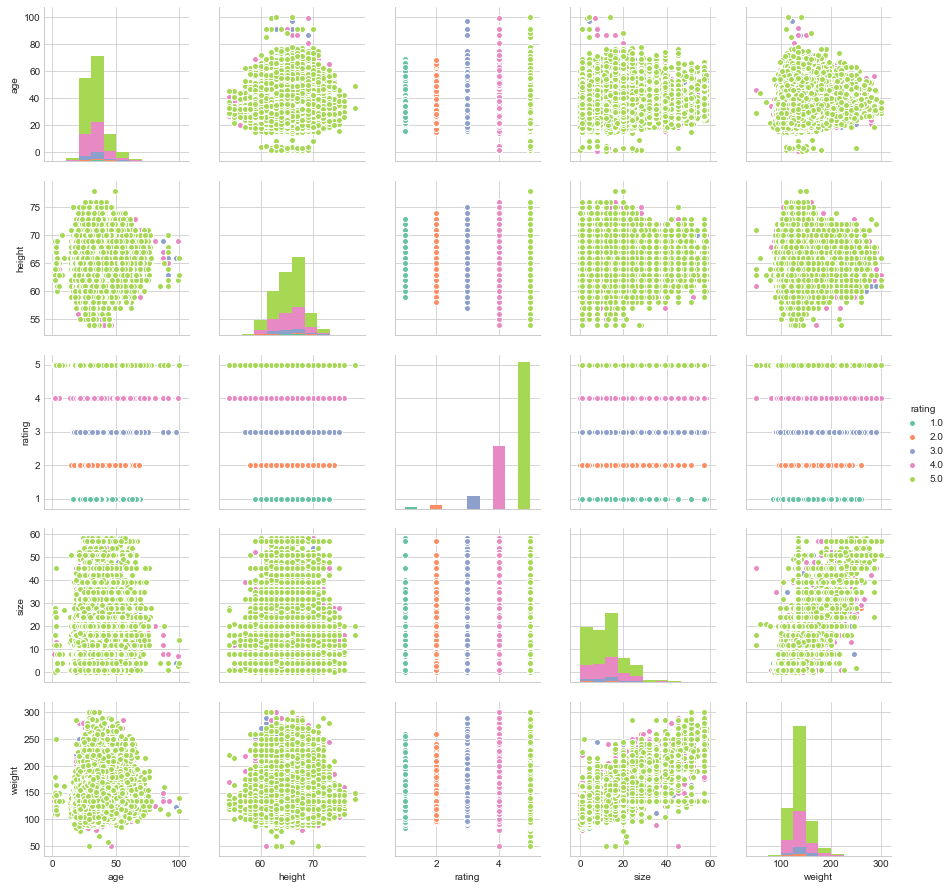

In [8]:
sns.set_style("whitegrid")

pairs_plot_df = fashion_data.drop(["item_id", "user_id", "review_summary", "review_text", "review_date"], axis=1)
sns.pairplot(pairs_plot_df, hue="rating", palette="Set2")

In [9]:
fashion_data[["age", "size", "height", "weight", "rating"]].describe().round(2)[1:]

,age,size,height,weight,rating
mean,33.84,12.25,65.31,137.02,4.55
std,7.89,8.50,2.66,20.14,0.72
min,1.00,0.00,54.00,50.00,1.00
25%,29.00,8.00,63.00,125.00,4.00
50%,32.00,12.00,65.00,135.00,5.00
75%,37.00,16.00,67.00,145.00,5.00
max,100.00,58.00,78.00,300.00,5.00


The recommender evaluation I've selected, which will be reviewed in a later section, requires a binary rating variable. As such, I've converted the rating scale to a 1/0. The logic is if a rental has been rated 5 or 4 and the item fit, the transaction becomes a hit (1). Otherwise, the transaction is a miss (0).

Text(0.5,1,'Rent-The-Runway product rating distribution: 25% quantile at 4')

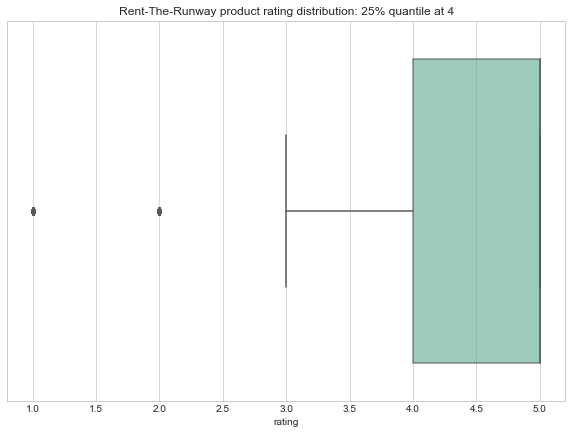

In [10]:
plt.figure(figsize=(10, 7))
sns.boxplot(fashion_data["rating"], orient="h", palette="Set2", boxprops=dict(alpha=.7))
plt.title("Rent-The-Runway product rating distribution: 25% quantile at 4")

In [11]:
pd.DataFrame(fashion_data.groupby("fit")["rating"].value_counts(normalize=True))

rating
fit   rating          
fit   5.0     0.709553
      4.0     0.246255
      3.0     0.035114
      2.0     0.007028
      1.0     0.002049
large 5.0     0.488964
      4.0     0.356000
      3.0     0.109838
      2.0     0.032441
      1.0     0.012758
small 5.0     0.454337
      4.0     0.373759
      3.0     0.116349
      2.0     0.038485
      1.0     0.017070

Text(0.5,1,'Rent-The-Runway product ratings: 5 and 4 ratings with fit become 1, otherwise 0')

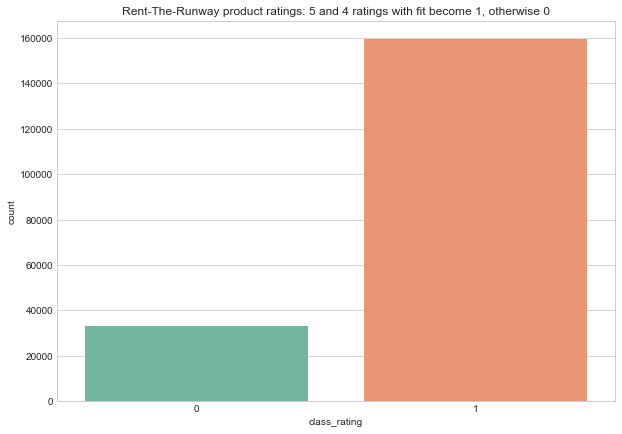

In [12]:
rating_to_binary = (fashion_data["rating"] == 5.0) | (fashion_data["rating"] == 4.0) & (fashion_data["fit"] == "fit")
fashion_data["class_rating"] = np.where(rating_to_binary == True, 1, 0)

plt.figure(figsize=(10, 7))
sns.countplot(x="class_rating", data=fashion_data, palette="Set2")
plt.title("Rent-The-Runway product ratings: 5 and 4 ratings with fit become 1, otherwise 0")

When reviewing class rating with some categorical variables, there are a few interesting insights:
- Body types are fairly close (means within .04). However, straight and narrow have highest
- Everyday and work items seem to be much lower than more formal events 
- Items that fit have higher rating (no surprises)

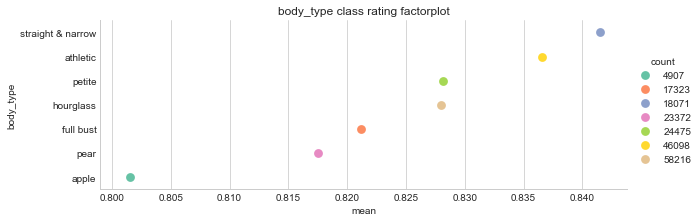

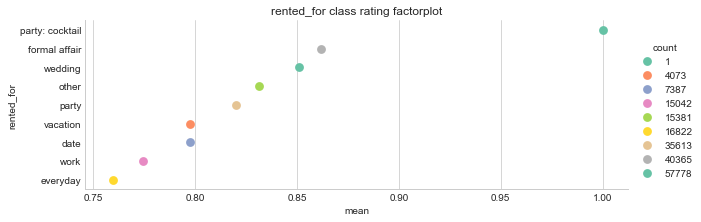

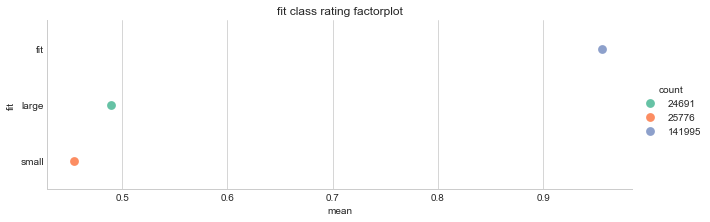

In [13]:
category_vars = ["body_type", "rented_for", "fit"]

for variable in category_vars:
    var_df = fashion_data.groupby(variable)["class_rating"].agg(["mean", "count"]).reset_index()
    var_df.sort_values(["mean"], ascending = False, inplace = True)
    sns.factorplot(y  = variable, x = "mean", 
                   orient = "h", 
                   hue = "count",
                   palette = "Set2",
                   size = 3, aspect = 3,
                   data = var_df)
    plt.title(variable + " " + "class rating factorplot")

The numeric variables show less interesting insights: Across height, weight, age, and size, there seems to be little difference between class rating medians.

Text(0.5,1,'Size vs Class Rating \n Medians appear equal')

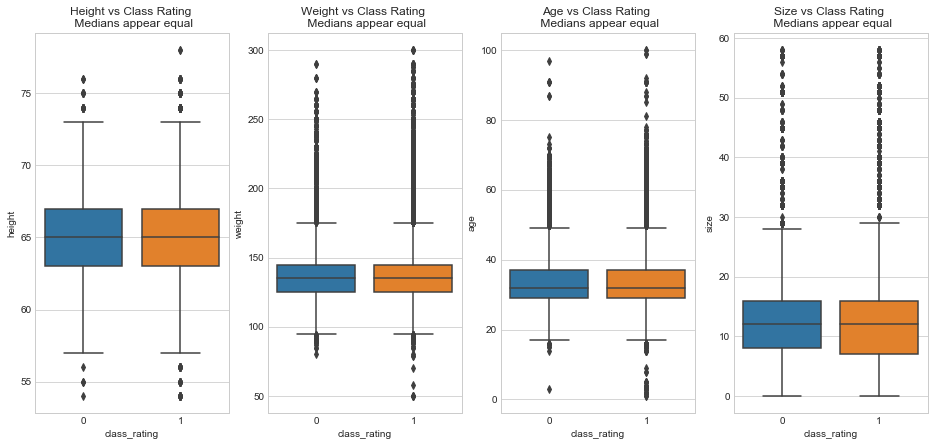

In [14]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 4, 1)
sns.boxplot(x = "class_rating", y = "height", data = fashion_data)
plt.title("Height vs Class Rating \n Medians appear equal")

plt.subplot(1, 4, 2)
sns.boxplot(x = "class_rating", y = "weight", data = fashion_data)
plt.title("Weight vs Class Rating \n Medians appear equal")

plt.subplot(1, 4, 3)
sns.boxplot(x = "class_rating", y = "age", data = fashion_data)
plt.title("Age vs Class Rating \n Medians appear equal")

plt.subplot(1, 4, 4)
sns.boxplot(x = "class_rating", y = "size", data = fashion_data)
plt.title("Size vs Class Rating \n Medians appear equal")

To ensure the recommender system is exposed to items with enough rental sample, thereby reducing noise, I wanted to filter out low-rental pieces. To provide an example of this, each item's rental count if visualized below. As seen in the right tail, many items have been rented very few times while the top items show strong repeat patterns. For this, I've included items with more than 3 rentals. The same process applies to users as well where only customers with more than 4 transactions are included. It's essential the user have a few training and test samples so the method evaluation can take place as well, which is satisfied here.

These plots also highlight that the customer base here has a small number of repeat buyers given the median transaction per user is 1. This might be something to review with a business audience in an attempt to develop strategies to increase repeat customers. That said, I'm not sure how this sample was obtained so there's a caveat on some of the insights. However, when looking around the Rent-the-runway site, they do offer subscriptions now, which could be an indication the company noticed trends like this. 

Text(0.5,1,'Low number of users have been purchased repeatedly \n median item buy count = 1.0 (blue line)')

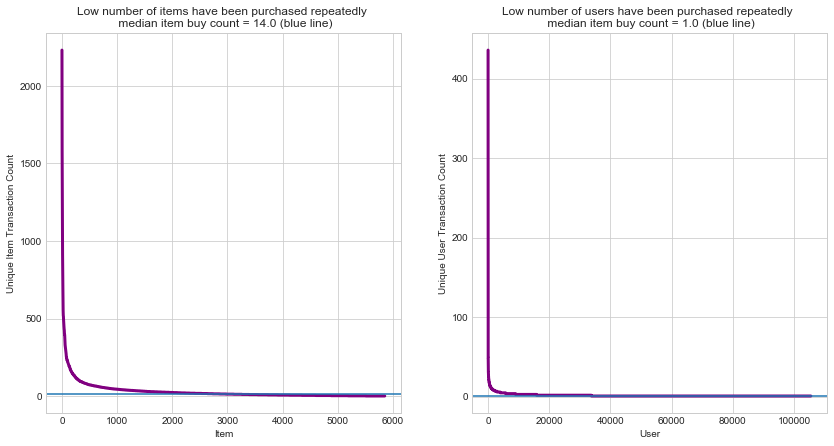

In [15]:
item_counts = fashion_data["item_id"].value_counts()
item_counts.sort_values(ascending = False, inplace = True)
item_x_axis = list(range(1, len(item_counts) + 1))
median_item_buy = np.median(item_counts)

user_counts = fashion_data["user_id"].value_counts()
user_counts.sort_values(ascending = False, inplace = True)
user_x_axis = list(range(1, len(user_counts) + 1))
median_user_buy = np.median(user_counts)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)

plt.plot(item_x_axis, item_counts, color="purple", linewidth = 3)
plt.xlabel("Item")
plt.axhline(median_item_buy)
plt.ylabel("Unique Item Transaction Count")
plt.title("Low number of items have been purchased repeatedly \n median item buy count = {mdn} (blue line)".format(mdn = median_item_buy))

plt.subplot(1, 2, 2)

plt.plot(user_x_axis, user_counts, color="purple", linewidth = 3)
plt.xlabel("User")
plt.axhline(median_user_buy)
plt.ylabel("Unique User Transaction Count")
plt.title("Low number of users have been purchased repeatedly \n median item buy count = {mdn} (blue line)".format(mdn = median_user_buy))

In [16]:
# including items with more than 3 ratings

item_rating_count = pd.DataFrame(fashion_data.groupby("item_id")["rating"].count())
item_rating_count = item_rating_count.loc[(item_rating_count["rating"] > 3)]
item_rating_count.reset_index(inplace=True)
fashion_reduced = fashion_data[fashion_data["item_id"].isin(item_rating_count["item_id"])]

# including users with more than 4 purchases

user_rating_count = pd.DataFrame(fashion_reduced.groupby("user_id")["rating"].count())
user_rating_count = user_rating_count.loc[(user_rating_count.rating > 4)]
user_rating_count.reset_index(inplace=True)
user_rating_count.drop("rating", axis=1, inplace=True)

fashion_reduced = fashion_reduced[fashion_reduced["user_id"].isin(user_rating_count["user_id"])]
fashion_reduced.reset_index(inplace=True, drop=True)

print("Final number of transcations in reduced set: {val:,}".format(val=len(fashion_reduced)))
print("Items with more than 3 ratings: {val:,}".format(val=fashion_reduced.item_id.nunique()))
print("Users with more than 4 ratings: {val:,}".format(val=fashion_reduced.user_id.nunique()))

Final number of transcations in reduced set: 49,909
Items with more than 3 ratings: 4,796
Users with more than 4 ratings: 5,631


The final reduced set shows about 81% of transactions are positive with the other 19% being misses.

In [17]:
# fashion_reduced.to_csv("rent_the_runway_reduced_data.csv", index=False)
# fashion_reduced = pd.read_csv("rent_the_runway_reduced_data.csv")

pd.DataFrame(fashion_reduced["class_rating"].value_counts(normalize=True))

,class_rating
1,0.806548
0,0.193452


## Recommender System Set-up

### Train and test split
- Selecting 80/20 train and test proportions
- User ID is stratified so each customer appears in both the training and test set

In [18]:
fashion_train, fashion_test = train_test_split(fashion_reduced,
                                               stratify=fashion_reduced["user_id"],
                                               test_size=.2, 
                                               random_state=1017)

print("Train size: {row:,}".format(row=fashion_train.shape[0]))
print("Test size: {row:,}".format(row=fashion_test.shape[0]))

Train size: 39,927
Test size: 9,982


### Evaluation Function Development

All the recommender approaches have a similar testing process. With this in mind, the functions below ensure they are being consistently evaluated:

- recommender_test_eval: For evaluating individual user metrics

- recommender_method_eval: For evaluating and gathering overall evaluation metrics for method

In [19]:
def recommender_test_eval(recommendations, user):
    '''
    function for evaluating individual users on recommender system
    recommendations: dataframe of the predictions for each user derived from recommender method
    user: unique int identifying customer
    output is dictionary with user id, how many ratings user has, how many were accurately recommended, and recall
    '''
    
    user_pref = fashion_test[fashion_test.user_id.isin([user])]
    items_in_60 = user_pref[user_pref.item_id.isin(recommendations.item_id)]
    
    recall_dict = {"user_id": user,
                   "ratings_count": len(user_pref),
                   "accurate_at_60": len(items_in_60[items_in_60.class_rating == 1]),
                   "recall_at_60": len(items_in_60[items_in_60.class_rating == 1]) / len(user_pref)}
                    
    return recall_dict

recommender_method_eval = pd.DataFrame()

def recommender_eval_gather(recommender, method, result=None):
    '''
    function for evaluating and gathering overall evaluation metric for recommender system
    recommender: recommender function that can be passed to perform all user test recs
    method: string passed to identify name of recommender system
    result: optional parameter based on value of recommender
    two options:
    recommender == None: pass result obtained by recommendation process, which function evaluates
    else: pass recommender to generate recommendation predictions which are then evaluated
    
    output is appended to data frame with all results. Includes recall mean @ 60 and recommender method name
    '''
        
    if recommender == None:
        method_result = pd.DataFrame({"Method": method, "Recall_mean@60": [result.mean()]})
        all_results = recommender_method_eval.append(method_result)
        
    else:
        result = pd.DataFrame([recommender(user) for user in fashion_test["user_id"].unique()], 
                               columns=["user_id", "accurate_at_60", "ratings_count", "recall_at_60"])
        method_result = pd.DataFrame({"Method": method, "Recall_mean@60": [result["recall_at_60"].mean()]})
        all_results = recommender_method_eval.append(method_result)
    
    return recommender_method_eval.append(all_results).sort_values("Recall_mean@60", ascending = False).drop_duplicates()

## Recommendation System Approaches

In total, I've developed 5 recommendation methods:

- Popularity
- Matrix Factorization (Collaborative Filtering)
- User K-means (Collaborative Filtering)
- TF-IDF Cosine Matrix (Content-Based Filtering)
- Item TF-IDF & Attribute K-NN (Content-Based Filtering)

Before getting into the methods, there's a few set up notes:
- Evaluation Metric: Mean Recall @ N
> - Evaluates whether the user's positive item (class rating = 1) is in the top-N suggested list of recommendations
> - More technically: True positives / (True positives + False negatives)
> - For example: If a user had 3 test transactions and 1 of the recommendations is correct, recall is .3333 (1 / 3)
> - Each user has an individual Recall @ N value; the overall recommender metric is the mean of those values
- N Selection: I've chosen 60 because on the Rent-the-runway site when you use their recommendation system, the first page is 60 items long. As such, the recommendation value is in line with the company's current practices.



### Popularity Recommender

The simplest, baseline approach where the item with the highest rating sum by body type is recommended. Including the body type adds a small amount of personalization but, the method is straightforward: recommend what's been rated highly most often.

In [20]:
ratings_df = pd.DataFrame(fashion_train.groupby(["body_type", "item_id"])["rating"].sum()).reset_index()
body_type_top_60 = ratings_df.groupby("body_type").head(60).sort_values(["body_type", "rating"], ascending=False).reset_index(drop=True)

def popular_recommender(id):
    user_pref = fashion_test[fashion_test.user_id.isin([id])]   
    user_body_top_60 = body_type_top_60[body_type_top_60.body_type.isin(user_pref.body_type)]
    
    return recommender_test_eval(recommendations = user_body_top_60, user = id)

test_user = 910934

popular_recommender(test_user)

{'accurate_at_60': 1,
 'ratings_count': 3,
 'recall_at_60': 0.3333333333333333,
 'user_id': 910934}

In [21]:
recommender_method_eval = recommender_eval_gather(recommender = popular_recommender, method = "Popular")
recommender_method_eval

,Method,Recall_mean@60
0,Popular,0.054564


### Collaborative Filtering

Collaborative filtering relies on similarities (cosine, Jaccardian, etc.) between users or items to derive recommendations. Here, I've included an example of each.

#### Item-based Matrix Factorization

Matrix factorization is underpinned by single value decomposition, a matrix decomposition method in linear algebra. The conceptual idea is to decompose a sparse matrix into three matrices that can then be used to generate predictions. From these, the top 60 per user are taken and recommended. This is the only method I didn't develop a recommender function for, opting instead to loop through the SVD process with different $k$ values (i.e. number of single values).

In [22]:
pivot_user_ratings = fashion_train.pivot_table(values="rating", 
                                               columns="item_id", 
                                               index="user_id", 
                                               aggfunc="count", 
                                               fill_value=0)

pivot_user_ratings.head()

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,...,2959486,2960025,2960940,2960969,2962646,2963344,2963850,2964470,2965009,2966087
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
pivot_user_ratings_mat = pivot_user_ratings.as_matrix()
user_means = np.mean(pivot_user_ratings_mat, axis=1)
pivot_user_ratings_mat = pivot_user_ratings_mat - user_means.reshape(-1, 1)

pivot_user_ratings_mat[:10]

array([[-0.00084495, -0.00084495, -0.00084495, ..., -0.00084495,
        -0.00084495, -0.00084495],
       [-0.00084495, -0.00084495, -0.00084495, ..., -0.00084495,
        -0.00084495, -0.00084495],
       [-0.00084495, -0.00084495, -0.00084495, ..., -0.00084495,
        -0.00084495, -0.00084495],
       ...,
       [-0.00084495, -0.00084495, -0.00084495, ..., -0.00084495,
        -0.00084495, -0.00084495],
       [-0.00105619, -0.00105619, -0.00105619, ..., -0.00105619,
        -0.00105619, -0.00105619],
       [-0.00084495, -0.00084495, -0.00084495, ..., -0.00084495,
        -0.00084495, -0.00084495]])

In [24]:
pivot_user_ratings_mat = pivot_user_ratings_mat.astype(float)

def mf_recommend_k_search(matrix, svd_k, user_ids):
    '''
    function for matrix-factorization process for recommendation engine with focus on finding SVD k
    svd_k: list of possible SVD k values that go through a loop and returns a mean for recall@60
    user_ids: unique user ids passed to get the recommendations, which are then used to calculate k batch mean for recall@60
    
    main loop: function takes svd k, conducts matrix decomp. on user rating matrix and then derives predictions with components
    nested loop: melted predictions are filtered by user id to get recommendations; metrics for each user is calculated
    
    final print out gives k value and mean for recall@60 for each k value
    '''
    
    mf_k_iterations = pd.DataFrame()
    iteration_count = 0
    
    for k in svd_k:
        print("_________________________")
        print("Starting MF_k_{0} loop".format(k))
        
        U, sigma, Vt = svds(matrix, k = k)
        sigma = np.diag(sigma)

        user_predictions = np.dot(np.dot(U, sigma), Vt) + user_means.reshape(-1, 1)
        user_predictions = pd.DataFrame(user_predictions, 
                                        index=pivot_user_ratings.index,
                                        columns=pivot_user_ratings.columns).reset_index()

        melted_preds = user_predictions.melt(id_vars="user_id")
        melted_preds.sort_values("value", ascending=False, inplace=True)

        mf_recommendations = pd.DataFrame()

        for id in user_ids:
            user_preds = melted_preds[melted_preds.user_id.isin([id])][:60]
            user_df = pd.DataFrame(recommender_test_eval(recommendations = user_preds, user = id), index=[0])
            mf_recommendations = pd.concat([mf_recommendations, user_df], axis=0)
            
        print("Finished MF_k_{0} loop".format(k))     
        k_iteration = recommender_eval_gather(recommender = None,
                                              method = "MF_k_{0}".format(k), 
                                              result = mf_recommendations["recall_at_60"])
        mf_k_iterations = pd.concat([k_iteration, mf_k_iterations], axis=0)
        iteration_count += 1
        
    print("\n")
    print("All {0} iterations have been completed".format(iteration_count))
    
    mf_k_iterations.drop_duplicates(inplace = True)
    
    return mf_k_iterations
                
svd_k_list = list(range(11, 15 + 1))
recommender_method_eval = mf_recommend_k_search(matrix = pivot_user_ratings_mat,
                                                svd_k = svd_k_list, 
                                                user_ids = fashion_test["user_id"].unique())
recommender_method_eval.sort_values("Recall_mean@60", inplace=True, ascending=False)
recommender_method_eval

_________________________
Starting MF_k_11 loop
Finished MF_k_11 loop
_________________________
Starting MF_k_12 loop
Finished MF_k_12 loop
_________________________
Starting MF_k_13 loop
Finished MF_k_13 loop
_________________________
Starting MF_k_14 loop
Finished MF_k_14 loop
_________________________
Starting MF_k_15 loop
Finished MF_k_15 loop


All 5 iterations have been completed


,Method,Recall_mean@60
0,MF_k_13,0.079812
0,MF_k_12,0.079382
0,MF_k_14,0.079057
0,MF_k_15,0.077157
0,MF_k_11,0.075296
0,Popular,0.054564


#### Clustering User-based Cosine Similarity Matrix

The second method here is user-based. The idea behind this is approach is recommending items similar users like. To enact this idea, I've developed k-means clusters using a user cosine similarity matrix that group users, and then make recommendations based on the membership. For example, users belonging to cluster 5 will all receive the same 60 recommendations. As such, this approach is not as personalized given it relies on group membership. The output highlights that while better than the popularity method, it lags behind item-based matrix factorization in this case.

In [25]:
user_rating_cosine = cosine_similarity(pivot_user_ratings, pivot_user_ratings)

def k_select(k):
    '''
    function to find optimal number of clusters for cosine similiarity matrix
    k: the number of cluster in the k-means solution
    output is dictionary with k and sum of square distance for cluster solution
    '''
    
    rating_kmeans = KMeans(n_clusters = k, max_iter = 400, 
                           algorithm = "auto", n_init = 30, random_state = 1017).fit(user_rating_cosine)
    ssq_dist = {"cluster_n": k,
                "ssq_dist": rating_kmeans.inertia_}
    return ssq_dist

In [26]:
k_options = list(range(2, 15 + 1))
kmean_ssq_dist = pd.DataFrame([k_select(k) for k in k_options])
pd.DataFrame(kmean_ssq_dist["ssq_dist"].diff()[1:])

,ssq_dist
1,-498.445403
2,-357.221434
3,-339.799565
4,-98.514915
5,-248.978537
6,-104.883684
7,-150.633714
8,-124.655722
9,-42.451954
10,-26.602188


Text(0.5,1,'Selecting k = 12 looks like a reasonable choice given variance plateau')

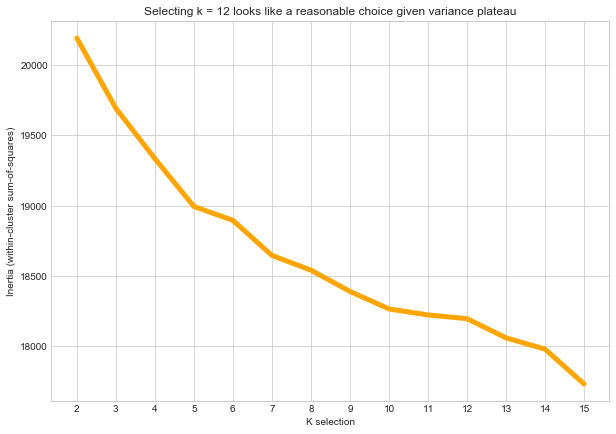

In [27]:
plt.figure(figsize=(10, 7))

plt.plot(kmean_ssq_dist["cluster_n"], kmean_ssq_dist["ssq_dist"], color="orange", linewidth = 5)
plt.xticks(k_options, k_options)
plt.xlabel("K selection")
plt.ylabel("Inertia (within-cluster sum-of-squares)")
plt.title("Selecting k = 12 looks like a reasonable choice given variance plateau")

In [28]:
rating_kmeans = KMeans(n_clusters = 12, max_iter = 400, 
                       algorithm = "auto", n_init = 30, 
                       random_state = 1017).fit(user_rating_cosine)
user_clusters = pd.DataFrame(rating_kmeans.labels_, columns=["cluster_n"])
pd.DataFrame(user_clusters["cluster_n"].value_counts())

,cluster_n
8,4556
0,357
6,135
1,107
9,92
2,85
7,74
10,59
3,58
4,45


In [29]:
pivot_user_ratings["cluster"] = list(rating_kmeans.labels_)
pivot_user_ratings[["cluster"]].head()

item_id,cluster
user_id,
47,8
332,2
551,8
657,8
836,8


In [30]:
cluster_items_melt = pivot_user_ratings.melt(id_vars="cluster", value_name="rating")
cluster_items_melt = pd.DataFrame(cluster_items_melt.groupby(["cluster", "item_id"])["rating"].mean())
cluster_items_melt.reset_index(inplace=True)
cluster_items_melt.sort_values(["cluster", "rating"], ascending=False, inplace=True)

cluster_items_melt.head()

,cluster,item_id,rating
52090,11,131117,1.000000
54047,11,1238932,0.083333
52084,11,127865,0.055556
52091,11,131533,0.055556
52094,11,132738,0.055556


In [31]:
pivot_user_ratings_copy = pivot_user_ratings.copy()
pivot_user_ratings_copy.reset_index(inplace=True)

def cosine_kmeans_recommender(id):
    '''
    function for matrix-factorization process for recommendation engine
    id: each user has a unique id which is passed to get the recommendations
    
    function takes id, filters to get user predictions, and then 
    '''
    
    user_and_cluster = pivot_user_ratings_copy[pivot_user_ratings_copy.user_id == [id]]
    user_cluster_ratings = cluster_items_melt[cluster_items_melt.cluster.isin(user_and_cluster.cluster)][:60]
                    
    return recommender_test_eval(recommendations = user_cluster_ratings, user = id)

cosine_kmeans_recommender(test_user)

{'accurate_at_60': 0,
 'ratings_count': 3,
 'recall_at_60': 0.0,
 'user_id': 910934}

In [32]:
recommender_method_eval = recommender_method_eval.iloc[[0, -1]]
recommender_method_eval = recommender_eval_gather(recommender = cosine_kmeans_recommender, method = "User_kmeans")
recommender_method_eval

,Method,Recall_mean@60
0,MF_k_13,0.079812
0,User_kmeans,0.066884
0,Popular,0.054564


### Content-Based Filtering

This class of methods generates recommendations based on the content of the actual items. For example, this often includes product descriptions and feature attributes. In this case, I'm stretching the definition here to include user reviews. Ideally, the set would have Rent-the-runway item descriptions but, in place, I'm using the user generated text instead. While this isn't ideal, given a user has to have write a review for it to be enacted, it's a reasonable substitute for learning purposes to show how the method works. As such, I'm making the assumption that the user reviews are comparable to the company's item text.

#### Item and User Text TF-IDF 

TF-IDF (Term Frequency Inverse Document Frequency) helps capture important words in series of documents. To do so, I'ce combined the user review, item category, and summary text into one field, which is used in the TF-IDF process. The cosine similarity of the TF-IDF is taken; this provides the item-based similarities based on text. To generate the predictions, each user's top rated item from the train set is used to get the 60 most similar items. The result shows that this method has the highest recall at 60 right now.

In [33]:
stop_words = stopwords.words("english")

fashion_train["item_review_text"] = (fashion_train["category"] + 
                                    " " +
                                    fashion_train["review_summary"] +
                                    " " +
                                    fashion_train["review_text"]).str.lower()
fashion_train["item_review_text"] = fashion_train["item_review_text"].astype(str)
fashion_train["item_review_text"] = fashion_train["item_review_text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop_words)])
)

fashion_train[["item_id", "item_review_text"]].tail()

,item_id,item_review_text
47102,474665,shirtdress nice pattern super sheer shirt unfo...
3468,1707266,dress flattering great fabric great design ton...
36706,1800907,dress perfect daytime vacation dress rented dr...
40311,1090219,dress comfortable fit nice flare skirt pretty ...
37281,479018,dress outdoor fl wedding fit like dream tried ...


In [34]:
agg_item_text = pd.DataFrame(fashion_train.groupby("item_id")["item_review_text"].sum())
agg_item_text.head()

,item_review_text
item_id,
123373,gown loved comfortable felt good totally recom...
123793,gown fabulously elegant dress comfortable wear...
124204,dress sassy sparkly shorter expected rented ga...
124553,dress classic comfortable great color first co...
125424,dress runs little large beautiful dress rented...


In [35]:
tf_idf = TfidfVectorizer()
tf_idf_matrix = tf_idf.fit_transform(agg_item_text["item_review_text"])
item_tfidf_similarity = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
item_tfidf_similarity_df = pd.DataFrame(item_tfidf_similarity,
                                        columns=agg_item_text.index,
                                        index=agg_item_text.index)

item_tfidf_similarity_df.head()

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,...,2959486,2960025,2960940,2960969,2962646,2963344,2963850,2964470,2965009,2966087
item_id,,,,,,,,,,,,,,,,,,,,,
123373,1.000000,0.575184,0.442646,0.506608,0.479016,0.538707,0.521699,0.525935,0.369026,0.512692,...,0.114674,0.092838,0.031872,0.101330,0.100206,0.116532,0.145158,0.051117,0.057676,0.195716
123793,0.575184,1.000000,0.625042,0.568643,0.532522,0.619371,0.581419,0.737026,0.420267,0.524273,...,0.121404,0.140211,0.053299,0.113103,0.087564,0.130336,0.124695,0.052004,0.070917,0.200478
124204,0.442646,0.625042,1.000000,0.557767,0.505196,0.467056,0.413303,0.708535,0.304050,0.524465,...,0.119139,0.079047,0.045667,0.108656,0.090111,0.140690,0.115424,0.073861,0.084117,0.145502
124553,0.506608,0.568643,0.557767,1.000000,0.645534,0.613361,0.497942,0.636101,0.373639,0.581661,...,0.151342,0.117722,0.059575,0.144036,0.141063,0.202935,0.185121,0.089758,0.070654,0.176001
125424,0.479016,0.532522,0.505196,0.645534,1.000000,0.493931,0.466861,0.601025,0.378125,0.545644,...,0.136687,0.098776,0.076901,0.173344,0.148665,0.170998,0.174330,0.093766,0.074103,0.173384


In [36]:
def tfidf_content_recommender(id):
    top_train_user_item = fashion_train[fashion_train.user_id == id][:1]
    top_train_user_item = int(top_train_user_item.item_id)
    item_similarities = item_tfidf_similarity_df[[top_train_user_item]].sort_values([top_train_user_item], ascending=False)
    top_60 = item_similarities.iloc[1:61]
    top_60.reset_index(inplace=True)
                    
    return recommender_test_eval(recommendations = top_60, user = id)

tfidf_content_recommender(test_user)

{'accurate_at_60': 0,
 'ratings_count': 3,
 'recall_at_60': 0.0,
 'user_id': 910934}

In [37]:
recommender_method_eval = recommender_eval_gather(recommender = tfidf_content_recommender, method = "Item_tfidf")
recommender_method_eval

,Method,Recall_mean@60
0,Item_tfidf,0.082248
0,MF_k_13,0.079812
0,User_kmeans,0.066884
0,Popular,0.054564


#### K-NN Modelling Recommender

Finally, the last method is developed using a machine learning model approach. Again, the TF-IDF matrix is used but, this time with the item category added to the data as columns (given they are dummy variables). From there, an unsupervised K-Nearest Neighbour model ($k = 3$) is then used to find the 60 top recommendations based on the user's top training set item. 

In [38]:
tf_idf = TfidfVectorizer(min_df = 5, max_features = 4000)
tf_idf_matrix = tf_idf.fit_transform(agg_item_text["item_review_text"])

knn_fashion_set = fashion_train[["item_id", "category"]]
knn_fashion_set.drop_duplicates("item_id", inplace=True)
knn_fashion_set.set_index(["item_id"], inplace=True)
tf_idf_matrix_df = pd.DataFrame(tf_idf_matrix.toarray(), index = agg_item_text.index)
knn_fashion_set = knn_fashion_set.join(tf_idf_matrix_df, how = "left")

category_dummies = pd.get_dummies(knn_fashion_set["category"])
knn_fashion_set.drop("category", axis = 1, inplace = True)
knn_fashion_set = pd.concat([knn_fashion_set, category_dummies], axis = 1)
print("Final K-NN set dimensions: {row:,} rows and {col:,} columns".format(row=knn_fashion_set.shape[0], 
                                                                           col=knn_fashion_set.shape[1]))
knn_fashion_set.head()

Final K-NN set dimensions: 4,734 rows and 4,064 columns


,0,1,2,3,4,5,6,7,8,9,...,tank,tee,tight,top,trench,trouser,trousers,tunic,turtleneck,vest
item_id,,,,,,,,,,,,,,,,,,,,,
315804,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
532252,0.000000,0.0,0.0,0.0,0.041448,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
181737,0.000000,0.0,0.0,0.0,0.060861,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1543130,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
166633,0.019812,0.0,0.0,0.0,0.040840,0.0,0.0,0.0,0.0,0.014576,...,0,0,0,0,0,0,0,0,0,0


In [39]:
ratings_knn = NearestNeighbors(metric = "euclidean", algorithm = "auto", n_neighbors = 3).fit(knn_fashion_set)

def knn_recommender(id):
    top_train_user_item = fashion_train[fashion_train.user_id == id][:1]
    top_train_user_item = int(top_train_user_item.item_id)
    distances, indices = ratings_knn.kneighbors(knn_fashion_set.loc[top_train_user_item].values.reshape(1, -1), 
                                                n_neighbors = 61)
    knn_top_60 = knn_fashion_set.iloc[indices.flatten()[1:61]]
    knn_top_60.reset_index(inplace=True)
    
    return recommender_test_eval(recommendations = knn_top_60, user = id)

knn_recommender(test_user)

{'accurate_at_60': 0,
 'ratings_count': 3,
 'recall_at_60': 0.0,
 'user_id': 910934}

In [40]:
recommender_method_eval = recommender_eval_gather(recommender = knn_recommender, method = "Item_knn")
recommender_method_eval

,Method,Recall_mean@60
0,Item_tfidf,0.082248
0,MF_k_13,0.079812
0,User_kmeans,0.066884
0,Item_knn,0.064167
0,Popular,0.054564


### Method Evaluation

With all the method evaluation metrics calculated, the final results can be seen below. The Content based TF-IDF performed best making it the most suitable choice.

Text(0.5,1,'Content-based filtering using tf-idf cosine matrix shows best performance')

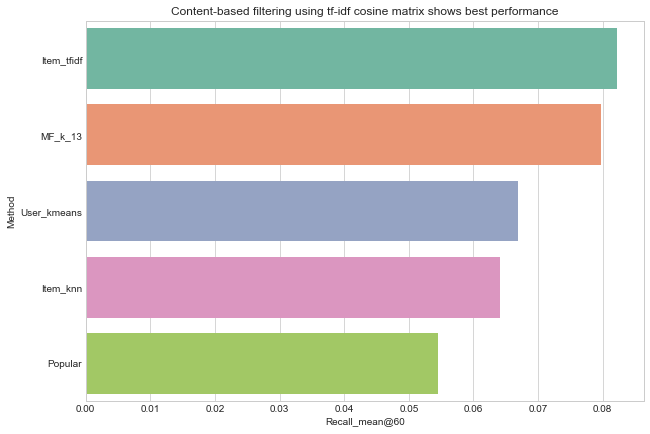

In [41]:
plt.figure(figsize=(10, 7))

sns.barplot(y = "Method", x = "Recall_mean@60", 
            orient = "h",
            order = list(recommender_method_eval["Method"]),
            palette = "Set2",
            data = recommender_method_eval)
plt.title("Content-based filtering using tf-idf cosine matrix shows best performance")

The item-based TF-IDF cosine similarity approach outperforms the baseline popularity method by about 51%. This method is the clear choice to move forward with.

In [42]:
rec_sys_baseline = recommender_method_eval["Recall_mean@60"].iloc[-1]
recommender_method_eval["Rank"] = list(range(1, 5 + 1))
recommender_method_eval["Percent_over_baseline"] = np.round(
    (recommender_method_eval["Recall_mean@60"] - rec_sys_baseline) / rec_sys_baseline * 100, 2
)

recommender_method_eval.set_index(["Rank"])

,Method,Recall_mean@60,Percent_over_baseline
Rank,,,
1,Item_tfidf,0.082248,50.74
2,MF_k_13,0.079812,46.27
3,User_kmeans,0.066884,22.58
4,Item_knn,0.064167,17.60
5,Popular,0.054564,0.00


## Future work
- Hybrid method: Weighted predictions from Matrix Factorization and Item-based TF-IDF may yield even better results
- Calculating business impact: With item prices, the increase in revenue generated by different methods could be reviewed to make the product impact more clear for a business audience

In [44]:
import os
os.getcwd()

# Command line for notebook to html conversion
#jupyter nbconvert --to html Rent_the_Runway_Customer_Analysis_Recommender_System.ipynb

'C:\\Users\\Mark\\Recommender System'